In [1]:
# Imports & helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, LogisticRegression
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set(style="whitegrid")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def print_reg_metrics(y_true, y_pred, prefix=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix}MSE: {mse:.4f}  RMSE: {rmse:.4f}  MAE: {mae:.4f}  R2: {r2:.4f}")
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [2]:
# Load dataset
try:
    mobile = pd.read_csv("Cellphone.csv")
except FileNotFoundError:
    print("mobile_price.csv not found. Please place your dataset in the working directory or adjust path.")
    mobile = None

if mobile is not None:
    print("Shape:", mobile.shape)
    display(mobile.head())


Shape: (161, 14)


,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


In [3]:
# Prepare X (design matrix) and y (labels)
# Drop rows with missing values
mobile = mobile.dropna()

# Features: drop target
X_df = mobile.drop(columns=['Price'])
y = mobile['Price'].values.reshape(-1,1)

# Convert categorical to numeric if needed
X_df = pd.get_dummies(X_df, drop_first=True)
feature_names = X_df.columns.tolist()
X = X_df.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print("Train shape:", X_train.shape, "\nTest shape:", X_test.shape)


Train shape: (128, 13) 
Test shape: (33, 13)


In [4]:
# Closed-form OLS (matrix solution)
def add_intercept(X):
    n = X.shape[0]
    return np.hstack([np.ones((n,1)), X])

Xtr = add_intercept(X_train)
Xte = add_intercept(X_test)

# closed-form solution
XtX = Xtr.T.dot(Xtr)
try:
    theta_closed = np.linalg.inv(XtX).dot(Xtr.T).dot(y_train)
except np.linalg.LinAlgError:
    print("X^T X singular; using pseudo-inverse.")
    theta_closed = np.linalg.pinv(XtX).dot(Xtr.T).dot(y_train)

# Predictions
y_pred_closed = Xte.dot(theta_closed)
print_reg_metrics(y_test, y_pred_closed, prefix="Closed-form OLS: ")

Closed-form OLS: MSE: 23062.2299  RMSE: 151.8625  MAE: 130.3153  R2: 0.9593


{'mse': 23062.22989175654,
 'rmse': np.float64(151.86253616924927),
 'mae': 130.31530961032558,
 'r2': 0.9593179111625627}

In [5]:
# Batch gradient descent for linear regression
def gradient_descent(X, y, lr=0.001, n_iters=50000, lambda_reg=0.0, verbose=False):
    m, n = X.shape
    theta = np.zeros(n)
    history = []

    for i in range(n_iters):
        preds = X.dot(theta)
        error = preds - y

        grad = (1/m) * (X.T.dot(error))
        grad[1:] += (lambda_reg / m) * theta[1:]

        grad = np.clip(grad, -1e4, 1e4)
        theta -= lr * grad
        loss = np.mean(error ** 2)
        history.append(loss)

    return theta, history

y_train = y_train.ravel()
y_test = y_test.ravel()

# --- Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Xtr_gd = add_intercept(X_train_scaled)
Xte_gd = add_intercept(X_test_scaled)

theta_gd, hist = gradient_descent(
    Xtr_gd, y_train,
    lr=0.0003,
    n_iters=50000,
    lambda_reg=0.0,
    verbose=True
)

# --- Predictions and evaluation ---
y_pred_gd = Xte_gd.dot(theta_gd)
print_reg_metrics(y_test, y_pred_gd, prefix="Gradient Descent (no reg): ")



Gradient Descent (no reg): MSE: 23167.5711  RMSE: 152.2090  MAE: 126.3514  R2: 0.9591


{'mse': 23167.57110856601,
 'rmse': np.float64(152.20897183992147),
 'mae': 126.3514243904471,
 'r2': 0.9591320878158786}

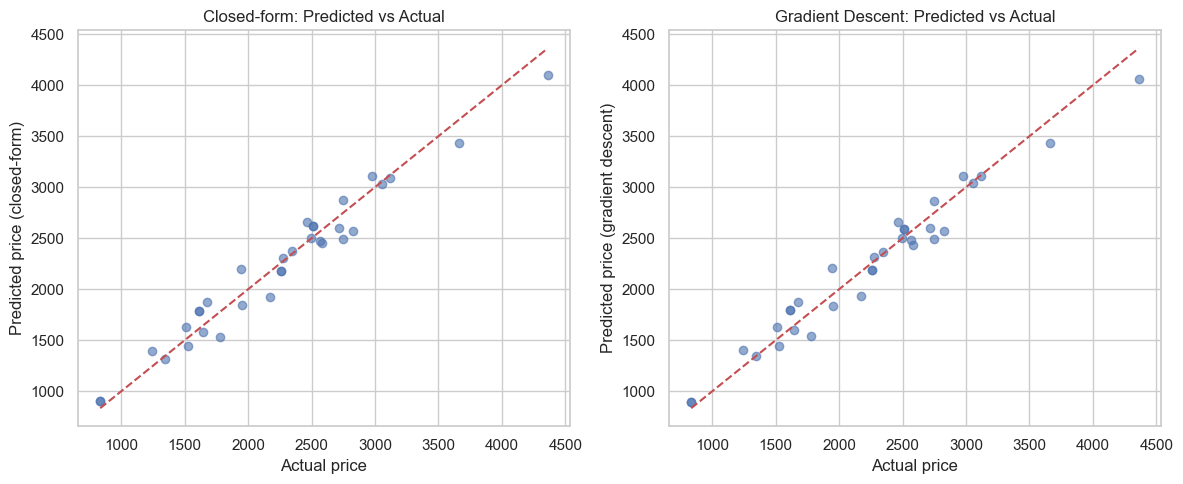

In [6]:
# Predicted vs actual (test)
if mobile is not None:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred_closed, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price (closed-form)")
    plt.title("Closed-form: Predicted vs Actual")

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_gd, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual price")
    plt.ylabel("Predicted price (gradient descent)")
    plt.title("Gradient Descent: Predicted vs Actual")
    plt.tight_layout()
    plt.show()


In [7]:
#Ridge Regression- closed form and gradient descent
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def add_intercept(X):
    return np.c_[np.ones(X.shape[0]), X]

Xtr = add_intercept(X_train_scaled)
Xte = add_intercept(X_test_scaled)

lam = 1.0
d = Xtr.shape[1]
I = np.eye(d)
I[0, 0] = 0

theta_ridge = np.linalg.inv(Xtr.T @ Xtr + lam * I) @ (Xtr.T @ y_train)
y_pred_ridge = Xte @ theta_ridge
print_reg_metrics(y_test, y_pred_ridge, prefix=f"Ridge closed-form (lambda={lam}): ")

def gradient_descent(X, y, lr=1e-4, n_iters=80000, lambda_reg=0.0, verbose=False):
    m, n = X.shape
    theta = np.zeros(n)
    history = []

    for i in range(n_iters):
        preds = X @ theta
        error = preds - y

        grad = (1/m) * (X.T @ error)
        grad[1:] += (lambda_reg / m) * theta[1:]
        theta -= lr * grad

        if i % 10000 == 0 and verbose:
            loss = np.mean(error**2)
            print(f"Iter {i}: Loss = {loss:.4f}")
        history.append(np.mean(error**2))

    return theta, history

theta_gd_ridge, hist_ridge = gradient_descent(
    Xtr, y_train, lr=1e-4, n_iters=80000, lambda_reg=lam, verbose=True
)
y_pred_gd_ridge = Xte @ theta_gd_ridge
print_reg_metrics(y_test, y_pred_gd_ridge, prefix=f"Ridge GD (lambda={lam}): ")


Ridge closed-form (lambda=1.0): MSE: 23254.3746  RMSE: 152.4939  MAE: 129.4628  R2: 0.9590
Iter 0: Loss = 5465383.1328
Iter 10000: Loss = 697525.3347
Iter 20000: Loss = 121930.1558
Iter 30000: Loss = 42891.7279
Iter 40000: Loss = 31589.7296
Iter 50000: Loss = 29707.4206
Iter 60000: Loss = 29227.0310
Iter 70000: Loss = 29007.0503
Ridge GD (lambda=1.0): MSE: 24160.3146  RMSE: 155.4359  MAE: 124.8918  R2: 0.9574


{'mse': 24160.31457676996,
 'rmse': np.float64(155.43588574318983),
 'mae': 124.89182644304465,
 'r2': 0.9573808747651105}

In [8]:
# Compare ridge with and without standardization
if mobile is not None:
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    Xtr_std = add_intercept(X_train_std)
    Xte_std = add_intercept(X_test_std)

    lam = 1.0
    I_std = np.eye(Xtr_std.shape[1]); I_std[0,0]=0
    theta_ridge_std = np.linalg.inv(Xtr_std.T.dot(Xtr_std) + lam * I_std).dot(Xtr_std.T).dot(y_train)
    y_pred_ridge_std = Xte_std.dot(theta_ridge_std)
    print_reg_metrics(y_test, y_pred_ridge_std, prefix="Ridge (standardized features): ")

    # Comparison
    print_reg_metrics(y_test, y_pred_ridge, prefix="Ridge (unstandardized features): ")


Ridge (standardized features): MSE: 23254.3746  RMSE: 152.4939  MAE: 129.4628  R2: 0.9590
Ridge (unstandardized features): MSE: 23254.3746  RMSE: 152.4939  MAE: 129.4628  R2: 0.9590


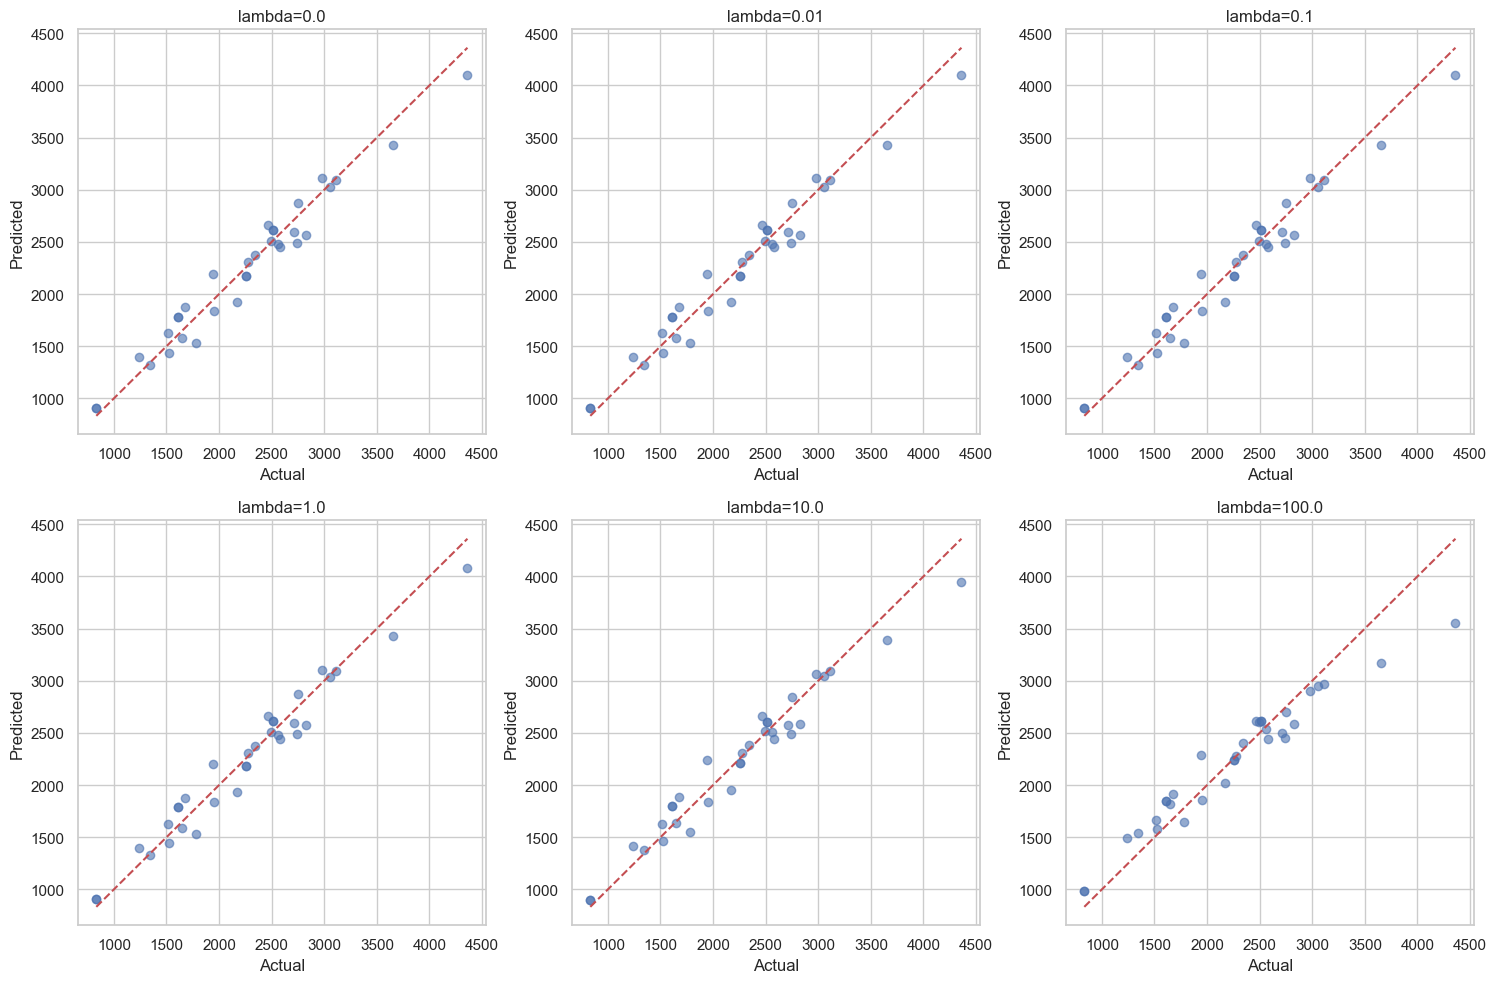

In [9]:
# Plot predicted vs actual scatter for different lamdas
if mobile is not None:
    lambdas = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
    fig, axes = plt.subplots(2, 3, figsize=(15,10))
    axes = axes.ravel()
    for i, lam in enumerate(lambdas):
        I = np.eye(Xtr.shape[1]); I[0,0]=0
        theta = np.linalg.inv(Xtr.T.dot(Xtr) + lam * I).dot(Xtr.T).dot(y_train)
        ypred = Xte.dot(theta)
        ax = axes[i]
        ax.scatter(y_test, ypred, alpha=0.6)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        ax.set_title(f"lambda={lam}")
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()


,feature,weight,abs_weight
11,battery,167.764104,167.764104
8,ram,162.837152,162.837152
12,thickness,-157.412005,157.412005
7,internal mem,156.179290,156.179290
4,ppi,152.088473,152.088473
5,cpu core,121.328660,121.328660
6,cpu freq,73.394720,73.394720
2,weight,-72.860199,72.860199
3,resoloution,-68.178626,68.178626
10,Front_Cam,35.613308,35.613308


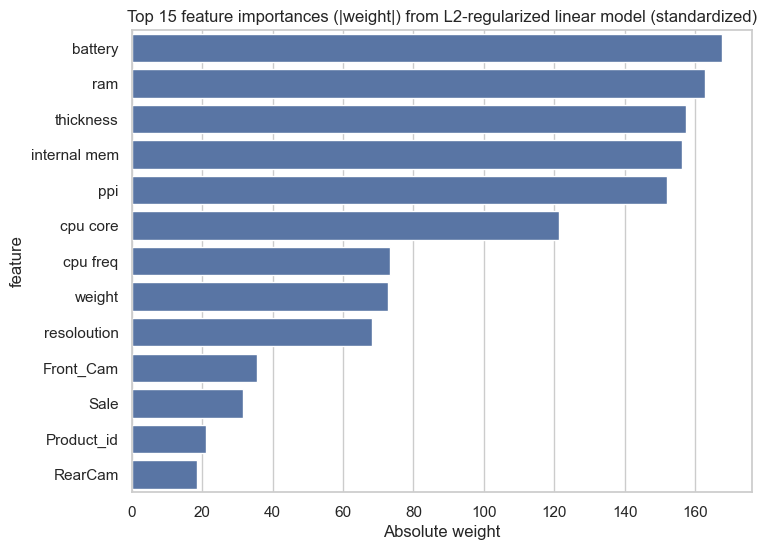

In [10]:
# Feature importance from ridge weights
if mobile is not None:
    coef = theta_ridge_std.flatten()
    intercept = coef[0]
    weights = coef[1:]
    importance = pd.DataFrame({"feature": feature_names, "weight": weights})
    importance['abs_weight'] = importance['weight'].abs()
    importance = importance.sort_values(by='abs_weight', ascending=False)
    display(importance.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(x='abs_weight', y='feature', data=importance.head(15))
    plt.title("Top 15 feature importances (|weight|) from L2-regularized linear model (standardized)")
    plt.xlabel("Absolute weight")
    plt.show()
